# `timex` example: Cradle-to-grave LCA of an electric vehicle

In [1]:
import bw2data as bd

bd.projects.set_current("bw25_premise")

## Prospective databases

Created using `premise` with updated electricity sectors

In [2]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

## Case study setup


Let's make sure we start from scratch:


In [3]:
del bd.databases["foreground"]
foreground = bd.Database("foreground")
foreground.write({})

Getting some input processes from the background database:


In [4]:
glider_production = bd.get_node(id=27559)
powertrain_production = bd.get_node(id=46481)  # eol included
battery_production = bd.get_node(id=41508)
electricity_production = bd.get_node(id=50069)
glider_eol = bd.get_node(id=46589)
battery_eol = bd.get_node(id=36946)

Creating the EV activity:


In [5]:
fg = bd.Database("foreground")

In [6]:
fg.new_node("EV_lifecycle", name="Electric vehicle, lifecycle", unit="unit").save()
ev_lifecycle = fg.get("EV_lifecycle")

Here are some parameter assumptions:


In [7]:
ELECTRICITY_CONSUMPTION = 0.2  # kWh/km
MILEAGE = 150_000  # km
LIFETIME = 16  # years

# Overall mass: 1200 kg
MASS_GLIDER = 840  # kg
MASS_POWERTRAIN = 80  # kg
MASS_BATTERY = 280  # kg

Based on these parameters, we create the following exchanges:


In [8]:
ev_lifecycle.new_edge(input=ev_lifecycle, amount=1, type="production").save()

In [9]:
glider_production_exchange = ev_lifecycle.new_edge(
    input=glider_production, amount=MASS_GLIDER, type="technosphere"
)

In [10]:
powertrain_production_exchange = ev_lifecycle.new_edge(
    input=powertrain_production, amount=MASS_POWERTRAIN, type="technosphere"
)

In [11]:
battery_production_exchange = ev_lifecycle.new_edge(
    input=battery_production, amount=MASS_BATTERY, type="technosphere"
)

In [12]:
electricity_production_exchange = ev_lifecycle.new_edge(
    input=electricity_production,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere",
)

In [13]:
glider_eol_exchange = ev_lifecycle.new_edge(
    input=glider_eol,
    amount=MASS_GLIDER,  # amount not negative as its not modeled as a "true" waste process
    type="technosphere",
)

In [14]:
battery_eol_exchange = ev_lifecycle.new_edge(
    input=battery_eol, amount=-MASS_BATTERY, type="technosphere"
)

Adding temporal distributions to the new exchanges:


In [15]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

In [16]:
td_production = easy_timedelta_distribution(
    start=-4,
    end=0,
    resolution="Y",  # M for months, Y for years, etc.
    steps=5,
    kind="triangular",
    param=-1,
)

td_use_phase = easy_timedelta_distribution(
    start=0,  # (inclusive)
    end=LIFETIME,  # (inclusive)
    resolution="Y",
    steps=(LIFETIME + 1),  # Includes both start and end
    kind="uniform",  # Could also be "triangular" or "uniform"
)

td_eol = TemporalDistribution(
    date=np.array([LIFETIME + 1], dtype="timedelta64[Y]"), amount=np.array([1])  # 2023
)

In [17]:
glider_production_exchange["temporal_distribution"] = td_production
glider_production_exchange.save()

powertrain_production_exchange["temporal_distribution"] = td_production
powertrain_production_exchange.save()

battery_production_exchange["temporal_distribution"] = td_production
battery_production_exchange.save()

electricity_production_exchange["temporal_distribution"] = td_use_phase
electricity_production_exchange.save()

glider_eol_exchange["temporal_distribution"] = td_eol
glider_eol_exchange.save()

battery_eol_exchange["temporal_distribution"] = td_eol
battery_eol_exchange.save()

## LCA using `timex`

In [18]:
method = ("EF v3.1", "climate change", "global warming potential (GWP100)")

In [19]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [20]:
from timex_lca import TimexLCA

tlca = TimexLCA({ev_lifecycle.key: 1}, method, database_date_dict, cutoff=1e-9)

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\timex_lca.py:86: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 7


In [21]:
tlca.build_timeline()

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\timeline_builder.py:324: Warning: Reference date 2041-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2021-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",140.0,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
1,2021-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",46.666667,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
2,2021-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",13.333333,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
3,2022-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",280.0,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
4,2022-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",93.333333,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
5,2022-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",26.666667,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
6,2023-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",420.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
7,2023-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",140.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
8,2023-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",40.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
9,2024-01-01,"market group for electricity, low voltage",2024-01-01,"Electric vehicle, lifecycle",1764.705882,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."


In [22]:
tlca.lci()

In [23]:
tlca.static_lcia()
tlca.score

15697.671323511528

In [24]:
co2_flows = [
    flow.id
    for flow in bd.Database("biosphere3")
    if "Carbon dioxide" in flow["name"] and "air" in flow["categories"]
]
ch4_flows = [
    flow.id
    for flow in bd.Database("biosphere3")
    if "Methane, fossil" in flow["name"]
    or "Methane, from soil or biomass stock" in flow["name"]
]
n2o_flows = [
    flow.id
    for flow in bd.Database("biosphere3")
    if "Dinitrogen monoxide" in flow["name"] and "air" in flow["categories"]
]

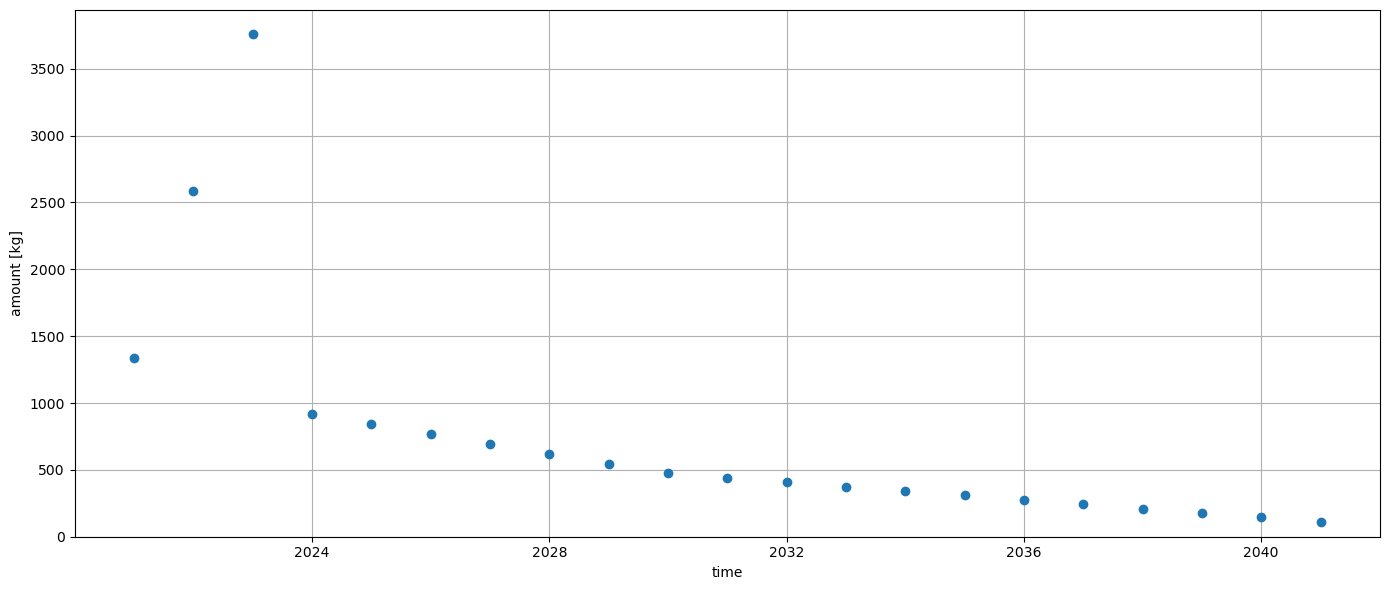

In [25]:
tlca.plot_dynamic_inventory(co2_flows, cumulative=False)

In [26]:
from timex_lca.utils import add_flows_to_characterization_function_dict
from timex_lca.dynamic_characterization import (
    characterize_co2,
    characterize_ch4,
    characterize_n2o,
)

In [27]:
cf_dict = add_flows_to_characterization_function_dict(co2_flows, characterize_co2)
cf_dict = add_flows_to_characterization_function_dict(ch4_flows, characterize_ch4)
cf_dict = add_flows_to_characterization_function_dict(n2o_flows, characterize_n2o)

In [28]:
tlca.dynamic_lcia(metric="radiative_forcing", fixed_TH=True, characterization_functions=cf_dict)

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2021-01-01 00:00:00,0.000000e+00,1168,"Carbon dioxide, fossil",27559,"(db_2020, 133b33cc867081af144475d62179286b)",0.000000e+00
29,2021-01-01 00:00:00,0.000000e+00,1649,"Methane, fossil",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",0.000000e+00
30,2021-01-01 00:00:00,0.000000e+00,3632,"Carbon dioxide, from soil or biomass stock",46481,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",0.000000e+00
31,2021-01-01 00:00:00,0.000000e+00,1649,"Methane, fossil",46481,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",0.000000e+00
32,2021-01-01 00:00:00,0.000000e+00,1164,"Carbon dioxide, non-fossil",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",0.000000e+00
...,...,...,...,...,...,...,...
47639,2123-01-01 21:14:24,9.232253e-20,3632,"Carbon dioxide, from soil or biomass stock",46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",1.490257e-09
47640,2123-01-01 21:14:24,3.167466e-18,4685,Dinitrogen monoxide,46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",1.490257e-09
47642,2123-01-01 21:14:24,1.462234e-14,114,"Carbon dioxide, non-fossil",36946,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",1.490272e-09
47644,2123-01-01 21:14:24,1.945344e-20,1169,"Carbon dioxide, fossil",36946,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",1.490276e-09


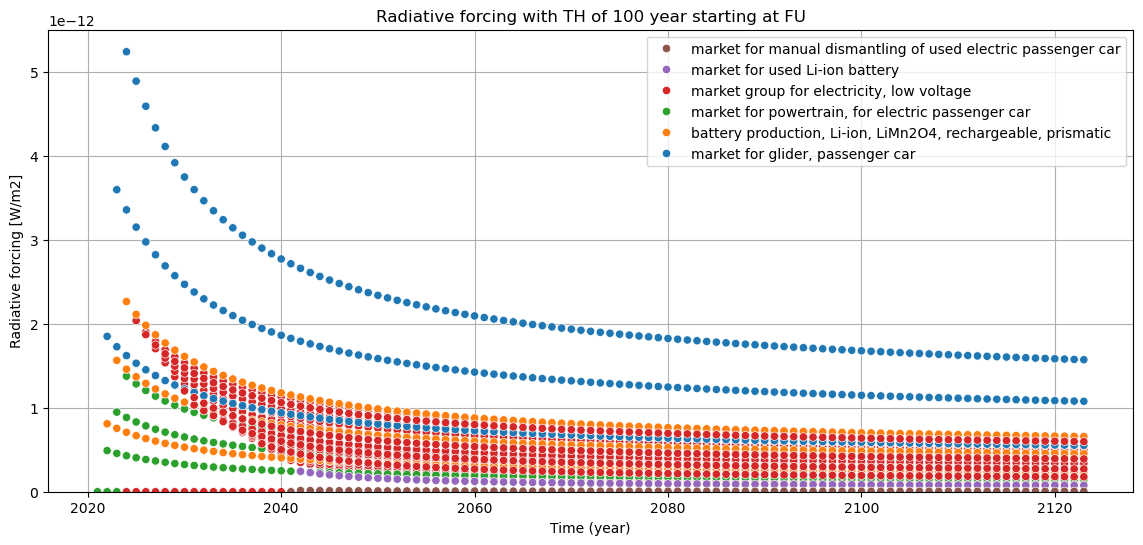

In [29]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

In [30]:
tlca.dynamic_lcia(metric="GWP", fixed_TH=True, characterization_functions=cf_dict)

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2021-01-01,3.776823e+02,1168,"Carbon dioxide, fossil",27559,"(db_2020, 133b33cc867081af144475d62179286b)",377.682347
29,2021-01-01,2.303194e+02,1168,"Carbon dioxide, fossil",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",1169.001889
30,2021-01-01,1.270399e+01,1167,"Carbon dioxide, non-fossil",27559,"(db_2020, 133b33cc867081af144475d62179286b)",1181.705883
31,2021-01-01,1.697456e+00,4685,Dinitrogen monoxide,27559,"(db_2020, 133b33cc867081af144475d62179286b)",1183.403339
32,2021-01-01,1.138307e-03,3630,"Methane, from soil or biomass stock",46481,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",1183.404477
...,...,...,...,...,...,...,...
480,2041-01-01,9.519776e-07,1169,"Carbon dioxide, fossil",46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",16726.227796
481,2041-01-01,6.345741e-03,3642,"Carbon dioxide, from soil or biomass stock",46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",16726.234142
482,2041-01-01,4.687242e-06,4686,Dinitrogen monoxide,46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",16726.234146
484,2041-01-01,3.043204e+00,1171,"Carbon dioxide, fossil",46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",16729.280146


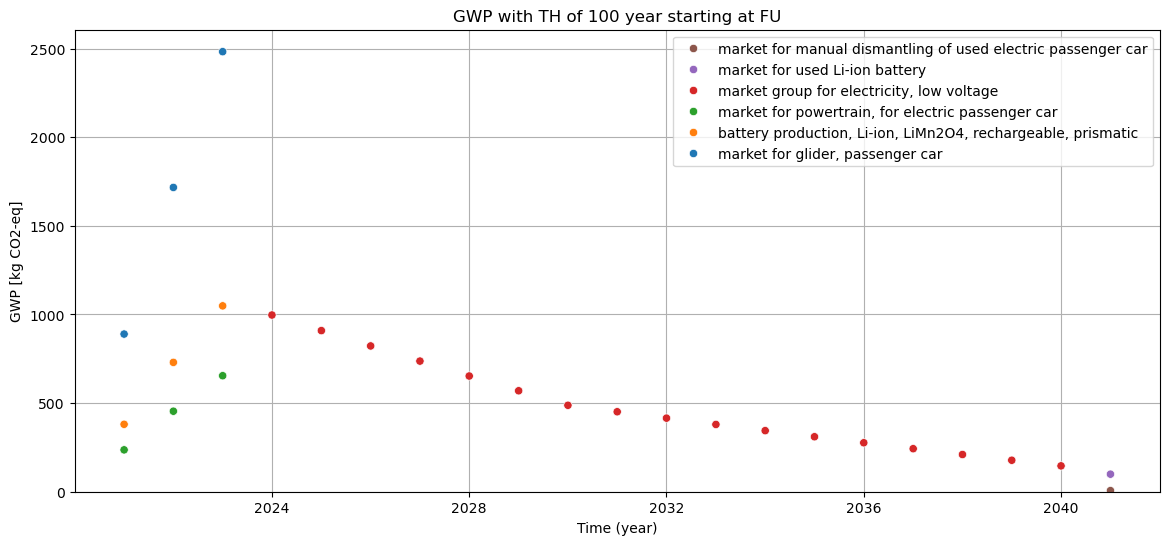

In [31]:
tlca.plot_dynamic_characterized_inventory(
    sum_emissions_within_activity=True, cumsum=False
)

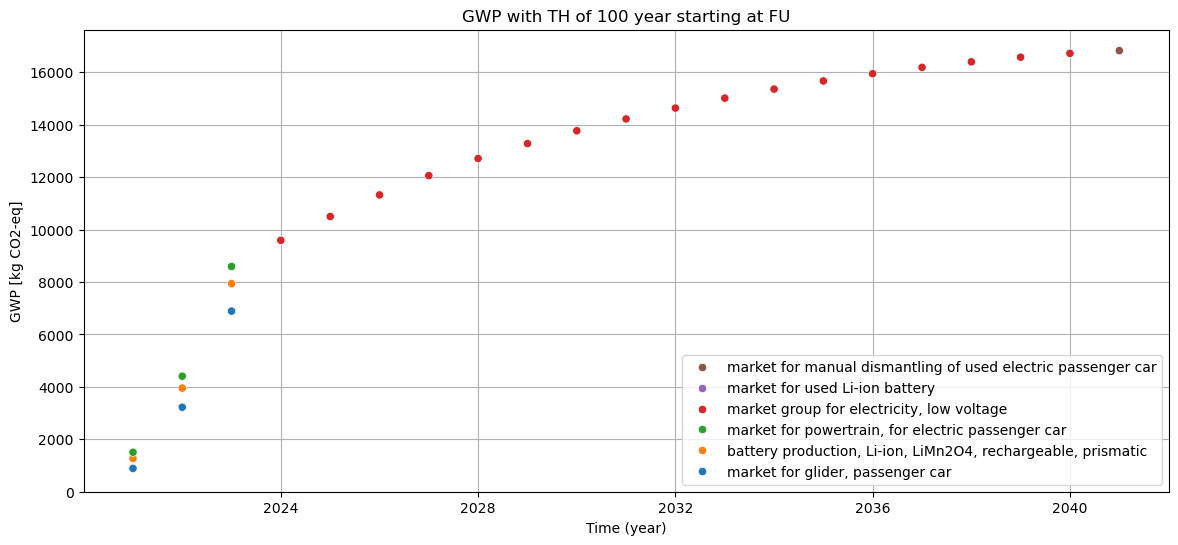

In [32]:
tlca.plot_dynamic_characterized_inventory(
    sum_emissions_within_activity=True, cumsum=True
)

In [33]:
import bw2calc as bc

static_scores = {}
for e in ev_lifecycle.exchanges():
    if e.input == ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    static_scores[e.input["name"]] = lca.score

In [34]:
prospective_ev_lifecycle = ev_lifecycle.copy()

In [35]:
for exc in prospective_ev_lifecycle.exchanges():
    if exc.input == prospective_ev_lifecycle:
        continue
    exc.input = bd.get_node(
        **{
            "database": "db_2040",
            "name": exc.input["name"],
            "product": exc.input["reference product"],
            "location": exc.input["location"],
        }
    )
    exc.save()

In [36]:
prospective_scores = {}
for e in prospective_ev_lifecycle.exchanges():
    if e.input == prospective_ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    prospective_scores[e.input["name"]] = lca.score

In [37]:
from timex_lca.utils import plot_characterized_inventory_as_waterfall

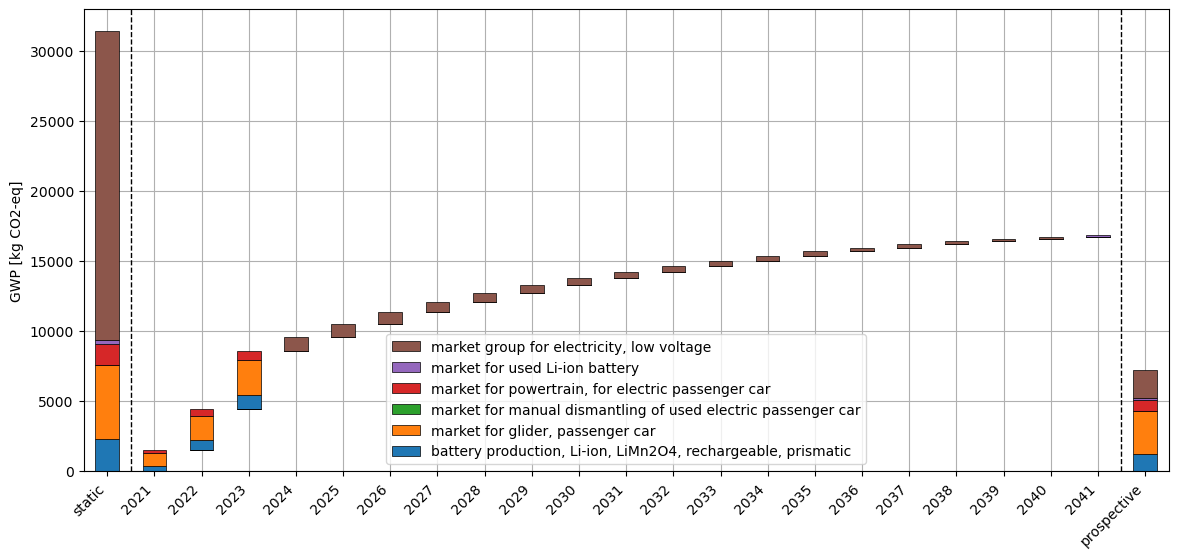

In [38]:
order_stacked_activities = [ #to sort stacked bars in waterfall plot chronologically from production to EoL
            "market for glider, passenger car",
            "market for powertrain, for electric passenger car",
            "battery production, Li-ion, LiMn2O4, rechargeable, prismatic",
            "market group for electricity, low voltage",
            "market for manual dismantling of used electric passenger car",
            "market for used Li-ion battery",
        ]

plot_characterized_inventory_as_waterfall(
    tlca.characterized_inventory,
    static_scores=static_scores,
    prospective_scores=prospective_scores,
    order_stacked_activities= order_stacked_activities,
)